In [1]:
import numpy as np
import pandas as pd
from scipy.stats import norm


<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


# Contingent Considerations

In [2]:
def black_scholes(S, K, T, r, sigma, option_type):
    """
    Calculate the Black-Scholes price of a call or put option.
    
    Parameters:
        S (float): Current stock price.
        K (float): Strike price.
        T (float): Time to expiration in years.
        r (float): Risk-free interest rate (annualized).
        sigma (float): Volatility of the stock (annualized).
        option_type (str): "call" for call option, "put" for put option.
    """
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)

    if option_type.lower() == "call":
        price = S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    elif option_type.lower() == "put":
        price = K * np.exp(-r * T) * norm.cdf(-d2) - S * norm.cdf(-d1)
    else:
        raise ValueError("Invalid option type. Use 'call' or 'put'.")
    
    return price, d1, d2

## 1. Linear Payoff Structure (EBITDA / Revenue)
> Company A will be required to pay 30% of the acquiree’s EBITDA earned over the subsequent one-year period. The payment is due three months after the end of the year.

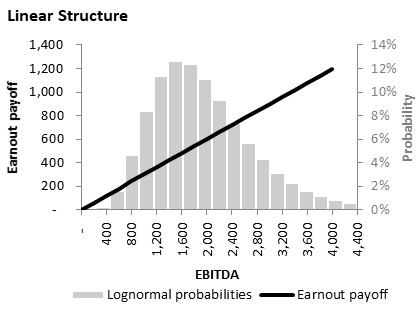

In [3]:
def lin_payoff(e_ebitda, c_rate, rf_rate, c_spread, th, t, T):
    """
    Calculate the present value of a linear earnout.
    
    Parameters:
        e_ebitda (float): Expected EBITDA.
        c_rate (float): Credit discount rate (including risk-free rate).
        rf_rate (float): Risk-free rate.
        c_spread (float): Credit spread.
        th (float): Threshold multiplier for earnout.
        t (float): Time to mid-period (years).
        T (float): Earnout maturity (years).
    """
    
    fv = e_ebitda * th  # Future value of earnout
    mid_disc = np.exp(-c_rate * (t / 2))  # Discount to mid-period
    rn_disc = np.exp(-rf_rate * (T - t / 2))  # Risk-neutral discount to t=0
    cs_disc = np.exp(-c_spread * T)  # Credit spread adjustment
    pv_earnout = fv * mid_disc * rn_disc * cs_disc
    
    return pv_earnout


# Calculate the linear earnout value
lin_earnout = lin_payoff(e_ebitda = 2000, c_rate = 0.1, rf_rate = 0.005, c_spread = 0.03, th = 0.3, t = 1, T = 1.25)
print(f"Value of Linear Payoff Earnout is: ${round(lin_earnout, 2)}")


Value of Linear Payoff Earnout is: $547.67


## 2. Technical Milestone Structure - Diversifiable Binary
> Company A will be required to pay 100 upon the achievement of a technical (nonfinancial) milestone that represents a diversifiable risk. The success or failure of achievement of the milestone will be determined in one year. The payment is due three months after the milestone is achieved.

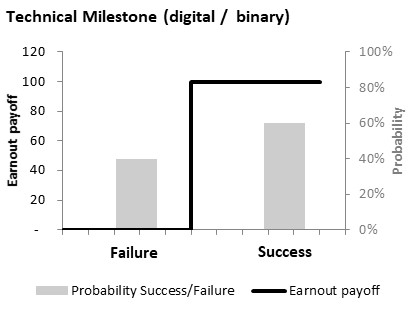

In [4]:
# Inputs / Assumptions:
def binary_payoff(e_ebitda, rf_rate, c_spread, th, T, beta = 0):
    
    fv = e_ebitda * th  # Future value of earnout
    sys_disc = np.exp(-beta * T)  # Discount rate for systematic risk
    rn_disc = np.exp(-rf_rate * T)  # Risk-neutral discount to t=0
    cs_disc = np.exp(-c_spread * T)  # Credit spread adjustment
    pv_earnout = fv * sys_disc * rn_disc * cs_disc
    
    return pv_earnout

bin_earnout = binary_payoff(e_ebitda = 100, rf_rate = 0.005, c_spread = 0.03, th = 0.6, T = 1.25)
print(f"Value of Earnout is: ${round(bin_earnout, 2)}")

Value of Earnout is: $57.43


## 3. Financial Milestone Structure - Systematic Binary (Long digital / binary call option)
> Company A will be required to pay 100 if the acquiree’s annual EBITDA exceeds 2,000 over the subsequent one-year period. The payment is due three months after the end of the year.

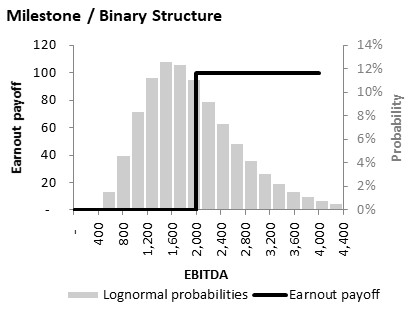

In [5]:
def systematic_binary_payoff(e_ebitda, payout, vol, c_rate, rf_rate, th, c_spread, t, T):
    
    exp_pv = e_ebitda * np.exp(-c_rate * (t / 2))  # Epxecte present value of earnout
    
    exp_earnout, d1, d2 = black_scholes(exp_pv, th, t/2, rf_rate, vol, 'call') # expected future risk-neutral earnout value
    
    # Since call option
    N_d1 = norm.cdf(d1)
    N_d2 = norm.cdf(d2)
    
    binary_option_value = payout * N_d2 
    
    cs_disc = np.exp(-(c_spread + rf_rate) * T)  # Credit spread + risk-free adjustment
    pv_earnout = binary_option_value * cs_disc
    
    return pv_earnout


sys_bin_earnout = systematic_binary_payoff(
    e_ebitda = 2000, payout = 100, vol = 0.5, c_rate = 0.1, rf_rate = 0.005, 
    c_spread = 0.03, th = 2000, t = 1, T = 1.25)

print(f"Value of Earnout is: ${round(sys_bin_earnout, 2)}")

Value of Earnout is: $36.17


## 4. Threshold Structure (Call Opiton)
> Company A will be required to pay 30% of the excess of the acquiree’s annual EBITDA above 2,000 over the subsequent one-year period. The payment is due three months after the end of the year.

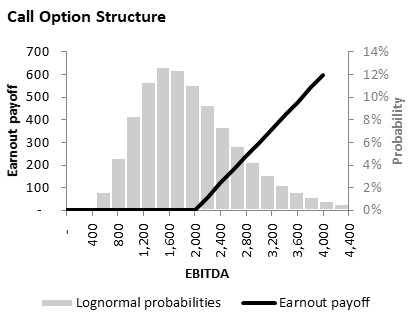

In [6]:
def threshold_call(e_ebitda, c_rate, th, rf_rate, vol, pmt_pct, c_spread, t, T):
    exp_pv = e_ebitda * np.exp(-c_rate * (t / 2))  # Epxecte present value of earnout
    
    exp_earnout, d1, d2 = black_scholes(exp_pv, th, t/2, rf_rate, vol, 'call') # expected future risk-neutral earnout value
    
    exp_fv_earnout = pmt_pct * exp_earnout 
    
    cs_disc = np.exp(-(c_spread + rf_rate) * T)  # Credit spread + risk-free adjustment
    pv_earnout = exp_fv_earnout * cs_disc * np.exp(rf_rate * (t / 2))
    
    return pv_earnout

threshold_earnout = threshold_call(
    e_ebitda = 2000, c_rate = 0.1, th = 2000, rf_rate = 0.005, vol = 0.5,  
    c_spread = 0.03, pmt_pct = 0.3, t = 1, T = 1.25)

print(f"Value of Earnout is: ${round(threshold_earnout, 2)}")

Value of Earnout is: $66.1


## 5. Asset or Nothing Structure
> Company A will be required to pay 30% of the acquiree’s annual EBITDA if the annual EBITDA exceeds 2,000 over the subsequent one-year period. The payment is due three months after the end of the year.

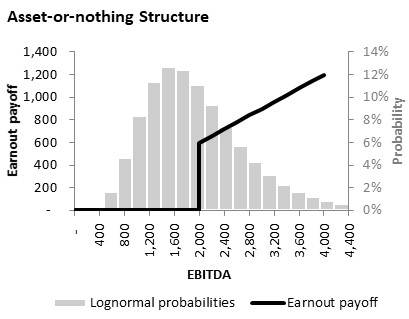

In [7]:
def asset_or_nothing(e_ebitda, c_rate, th, rf_rate, vol, pmt_pct, c_spread, t, T):
    exp_pv = e_ebitda * np.exp(-c_rate * (t / 2))  # Epxecte present value of earnout
    
    exp_earnout, d1, d2 = black_scholes(exp_pv, th, t/2, rf_rate, vol, 'call') # expected future risk-neutral earnout value
    N_d1 = norm.cdf(d1)
    N_d2 = norm.cdf(d2)
    
    exp_fv_earnout = (th * N_d2 * pmt_pct + pmt_pct * exp_earnout) * np.exp(rf_rate * (t / 2))
    
    cs_disc = np.exp(-(c_spread + rf_rate) * T)  # Credit spread + risk-free adjustment
    pv_earnout = exp_fv_earnout * cs_disc
    
    return pv_earnout

asset_nothing_earnout = asset_or_nothing(
    e_ebitda = 2000, c_rate = 0.1, th = 2000, rf_rate = 0.005, vol = 0.5,  
    c_spread = 0.03, pmt_pct = 0.3, t = 1, T = 1.25)

print(f"Value of Earnout is: ${round(asset_nothing_earnout, 2)}")

Value of Earnout is: $283.65


## 6. Capped Call Structure
> Company A will be required to pay 30% of the excess of the acquiree’s annual EBITDA above 2,000 over the subsequent one-year period with a payment cap of 300. The payment is due three months after the end of the year.

- 300 / 30% = 1000. Therefore second strike = 2000 + 1000 = 3000

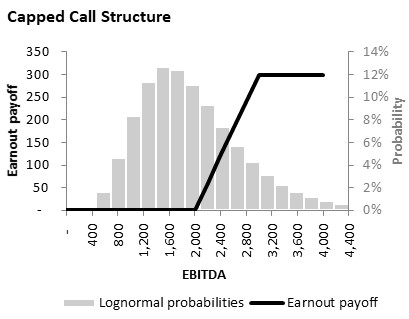

In [8]:
def capped_call(e_ebitda, c_rate, th1, th2, rf_rate, vol, pmt_pct, c_spread, t, T):
    exp_pv = e_ebitda * np.exp(-c_rate * (t / 2))  # Epxecte present value of earnout
    
    exp_earnout1, d1_1, d2_1 = black_scholes(exp_pv, th1, t/2, rf_rate, vol, 'call') # expected future risk-neutral earnout value
    exp_earnout2, d1_2, d2_2 = black_scholes(exp_pv, th2, t/2, rf_rate, vol, 'call')
    
    exp_fv_earnout = (exp_earnout1 * pmt_pct - pmt_pct * exp_earnout2) * np.exp(rf_rate * (t / 2))
    
    cs_disc = np.exp(-(c_spread + rf_rate) * T)  # Credit spread + risk-free adjustment
    pv_earnout = exp_fv_earnout * cs_disc
    
    return pv_earnout

capped_call_earnout = capped_call(
    e_ebitda = 2000, c_rate = 0.1, th1 = 2000, th2 = 3000, rf_rate = 0.005, vol = 0.5,  
    c_spread = 0.03, pmt_pct = 0.3, t = 1, T = 1.25)

print(f"Value of Earnout is: ${round(capped_call_earnout, 2)}")

Value of Earnout is: $54.71


## 7. Tiered Payoff Structure
> Company A will be required to pay 30% of the excess of the acquiree’s annual EBITDA above 2,000, plus 10% of the excess annual EBITDA above 2,400 over the subsequent one-year period with a payment cap of 200. The payment is due three months after the end of the year.
- Excess till 2400 = 2400 - 2000 = 400
- Payment = 30% * 400 = 120
- Cap = 200. Remaining amount = 200-120 = 80
- Strik_3 = 80 / 10% = 800 --> 800 + 2400 = 3200

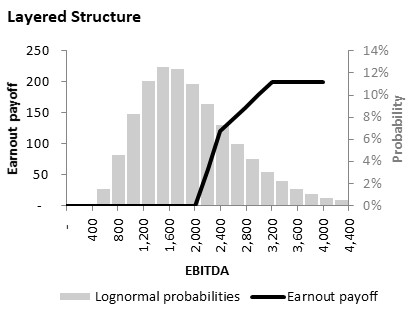

In [9]:
def tiered_payoff(e_ebitda, c_rate, th1, th2, th3, rf_rate, vol, pmt_pct1, pmt_pct2, c_spread, t, T):
    exp_pv = e_ebitda * np.exp(-c_rate * (t / 2))  # Epxecte present value of earnout
    
    exp_earnout1, d1_1, d2_1 = black_scholes(exp_pv, th1, t/2, rf_rate, vol, 'call') # expected future risk-neutral earnout value
    exp_earnout2, d1_2, d2_2 = black_scholes(exp_pv, th2, t/2, rf_rate, vol, 'call')
    exp_earnout3, d1_3, d2_3 = black_scholes(exp_pv, th3, t/2, rf_rate, vol, 'call')
    
    exp_fv_earnout = (exp_earnout1 * pmt_pct1 - (pmt_pct1 - pmt_pct2) * exp_earnout2 - pmt_pct2 * exp_earnout3) * np.exp(rf_rate * (t / 2))
    
    cs_disc = np.exp(-(c_spread + rf_rate) * T)  # Credit spread + risk-free adjustment
    pv_earnout = exp_fv_earnout * cs_disc
    
    return pv_earnout

tiered_earnout = tiered_payoff(
    e_ebitda = 2000, c_rate = 0.1, th1 = 2000, th2 = 2400, th3 = 3200, rf_rate = 0.005, vol = 0.5,  
    c_spread = 0.03, pmt_pct1 = 0.3, pmt_pct2 = 0.1, t = 1, T = 1.25)

print(f"Value of Earnout is: ${round(tiered_earnout, 2)}")

Value of Earnout is: $41.16
